# Batch Normalization

Reference
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
class Net(nn.Module):
    def __init__(self, activation_f, batch_norm=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)
        
        self.f = activation_f
        self.batch_norm = batch_norm
        self.activation_value = {}

    def forward(self, x):
        if self.batch_norm:
            x = self.f(self.bn1(self.fc1(x)))
            self.activation_value[1] = x
            x = self.f(self.bn2(self.fc2(x)))
            self.activation_value[2] = x
            x = self.f(self.bn3(self.fc3(x)))
            self.activation_value[3] = x
            x = self.f(self.bn4(self.fc4(x)))
            self.activation_value[4] = x
            x = self.f(self.bn5(self.fc5(x)))
            self.activation_value[5] = x
        else:
            x = self.f(self.fc1(x))
            self.activation_value[1] = x
            x = self.f(self.fc2(x))
            self.activation_value[2] = x
            x = self.f(self.fc3(x))
            self.activation_value[3] = x
            x = self.f(self.fc4(x))
            self.activation_value[4] = x
            x = self.f(self.fc5(x))
            self.activation_value[5] = x
        
        return self.fc6(x)

    def init_normal(self, std):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.normal_(p.weight, mean=0.0, std=std)
                nn.init.constant_(p.bias, 0.0)
                
    def init_kaiming_normal(self):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.kaiming_normal_(p.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(p.bias, 0.0)
                
    def init_xavier_normal(self):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.xavier_normal_(p.weight, gain=1.0)
                nn.init.constant_(p.bias, 0.0)


In [25]:
def get_activation_df(activation_f, sigma, x_std=0.5, batch_size=10, batch_norm=False):
    model = Net(activation_f, batch_norm=batch_norm)
    model.init_normal(sigma)

    x = torch.normal(0, x_std, [batch_size,16])
    y = model(x)

    activation_per_layer = []

    for i in range(1,6):
        activation_per_layer.append(np.c_[
            np.repeat(sigma, 64*batch_size), 
            np.repeat(i, 64*batch_size), 
            model.activation_value[i].detach().numpy().flatten()
        ])

    df = pd.DataFrame(np.concatenate(activation_per_layer, axis=0), columns=['Standard Deviation', 'Hidden Layer', 'Output'])
    
    return df

In [4]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def get_activation_plot(df, activation, initialization, sigmas):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    height = len(sigmas)*3
    
    fig = plt.figure(figsize=(12, height))
    axes = grid_axes_it(len(sigmas), 1, fig=fig)
    for sig in sigmas:
        ax = next(axes)
        if initialization == 'normal':
            ddf = df[df['Standard Deviation'] == sig]
        else:
            ddf = df
        
        sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if initialization == 'normal':
            title_str = 'Initialization: [init] | Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$'
            title_str = title_str.replace("[init]", initialization)
            ax.set_title(title_str % sig, fontsize=13)
        else: 
            title_str = 'Initialization: [init]'.replace("[init]", initialization)
            ax.set_title(title_str, fontsize=13)

        if initialization == 'normal':
            if sig == sigmas[1]:
                ax.set_ylabel("[act] | Neuron Outputs".replace("[act]", activation))
            if sig != sigmas[-1]:
                ax.set_xticklabels(())
            else:
                ax.set_xlabel("Hidden Layer")
        else:
            ax.set_ylabel("[act] | Neuron Outputs".replace("[act]", activation))
            ax.set_xticklabels(())
            ax.set_xlabel("Hidden Layer")

    plt.tight_layout()
    plt.show()

## Activation: ReLU | Normal initialization | Post activation distribution
Below are violin plot of post activation distribution: `F.relu(x)`
- Without Batch Norm: Activation depends on initialization, likely result in vanishing / exploding gradients
- With Batch Norm: Reduced dependency on initialization

/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


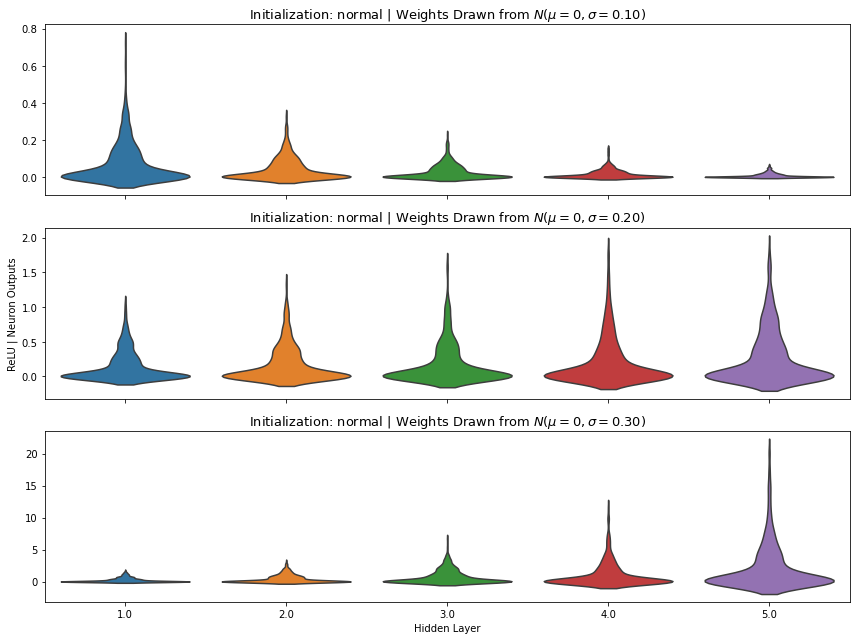

In [28]:
sigma_list = [0.10, 0.2, 0.3]
df_list = []

for sigma in sigma_list:    
    df_list.append(get_activation_df(F.relu, sigma, batch_norm=False))
    
dff = pd.concat(df_list)
get_activation_plot(dff, 'ReLU', 'normal', sigma_list)

/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_11855/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


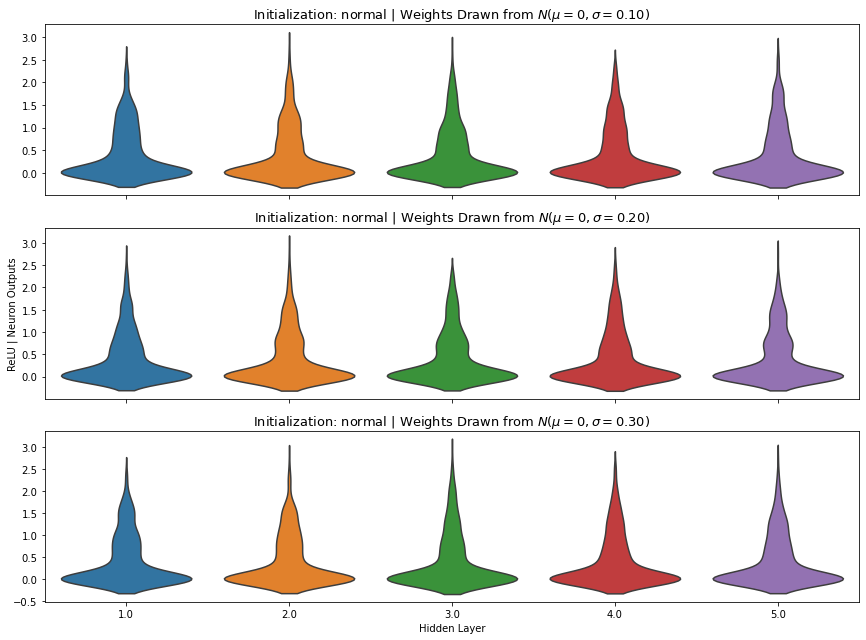

In [27]:
sigma_list = [0.10, 0.2, 0.3]
df_list = []

for sigma in sigma_list:    
    df_list.append(get_activation_df(F.relu, sigma, batch_norm=True))
    
dff = pd.concat(df_list)
get_activation_plot(dff, 'ReLU', 'normal', sigma_list)